In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sys.path.insert(0, '../kinetic_analysis')
from kinetic_function import (single_track_analysis,
                              generate_track
                             )

In [2]:
prot_aa_size = {
    "32xsuntag": 796,  #768/32=24 , left 28
    "linker": 4,
    "twist": 490,
    "ilp4": 134,
    "snail": 390,
    "very_long_prot":2000, 
}

In [3]:
path_save = "/home/u2175049/Documents/Code/KineticAnalysis/notebook/figures/"
path = "/mnt/sda1/Sophie/2-KineticAnalysisData/2-Datas/05-Modelling/07_ElongationRate/"

In [111]:
first_time = True
for elong_r in [0.5, 1, 2.5, 5, 10, 20, 30, 40]:
    for i in range(100):
        x_global, y_global, y_start_prot = generate_track(prot_length = prot_aa_size["snail"], 
                                                          suntag_length = prot_aa_size["32xsuntag"],
                                                          nb_suntag=32, 
                                                          fluo_one_suntag=4, 
                                                          translation_rate=elong_r, 
                                                          binding_rate=0.05,
                                                          retention_time=0,
                                                          suntag_pos="begin",
                                                          step = 0.1,
                                                          length=6000)
        if first_time:
            datas = pd.DataFrame({"FRAME":x_global,
                                  "MEAN_INTENSITY_CH1":y_global,
                                  "TRACK_ID" : i,
                                  "ELONGATION_RATE":elong_r,
                                 })
            first_time = False
        else:
            datas = pd.concat([datas, 
                               pd.DataFrame({"FRAME":x_global,
                                              "MEAN_INTENSITY_CH1":y_global,
                                              "TRACK_ID" : i,
                                             "ELONGATION_RATE":elong_r,
                                 })], ignore_index=True)


datas.to_csv(os.path.join(path, "datas_elongation_rate.csv"))

In [4]:
datas = pd.read_csv(os.path.join(path, "datas_elongation_rate.csv"), index_col="Unnamed: 0")

In [5]:
datas.head()

,FRAME,MEAN_INTENSITY_CH1,TRACK_ID,ELONGATION_RATE
0,0.0,37.973869,0,0.5
1,0.1,38.006030,0,0.5
2,0.2,38.038191,0,0.5
3,0.3,38.070352,0,0.5
4,0.4,38.102513,0,0.5


In [21]:
first_time = True
dt = 3
t = dt/0.1
for elong_r in [0.5,1, 2.5, 5, 10, 20, 30, 40]:
    prot_length = prot_aa_size["32xsuntag"]+prot_aa_size["snail"]
    for i in range(100):
        datas2 =datas[(datas["TRACK_ID"]==i) & (datas["ELONGATION_RATE"]==elong_r)][::int(t)]
        (x, 
        y, 
        x_auto, 
        y_auto, 
        elongation_r, 
        translation_init_r,
        perr) = single_track_analysis(datas2,
                                     i, 
                                     delta_t = dt,
                                     protein_size=prot_length,
                                     normalise_intensity=1,
                                     normalise_auto=True,
                                     mm=None,
                                     lowpass_=False,
                                     cutoff=100,
                                     rtol=1e-1,
                                     method="linear",
                                     force_analysis=True,
                                     first_dot=True,
                                     simulation=True)
        if first_time:
            results = pd.DataFrame({"elongation_r":elongation_r, 
                                    "init_translation_r":translation_init_r, 
                                    "dt":dt,
                                   "id":i,
                                   "elongation_rate":elong_r},
                                  index=[0])
            first_time = False
        
        else:
            results = pd.concat([results, 
                            pd.DataFrame({"elongation_r":elongation_r, 
                                          "init_translation_r":translation_init_r, 
                                          "dt":dt, 
                                          "id":i,
                                         "elongation_rate":elong_r}, index=[0])
                            ], ignore_index=True)
results.to_csv(os.path.join(path, "results_elongation_rate.csv"))

In [7]:
results.groupby(by='elongation_rate')[['elongation_r','init_translation_r']].mean()

,elongation_r,init_translation_r
elongation_rate,,
0.5,0.354123,798.631619
1.0,0.994995,114.869654
2.5,2.497317,31.771818
5.0,4.631341,26.061230
10.0,8.619040,28.172833
20.0,17.266466,27.979705
30.0,26.240754,27.420938
40.0,33.157179,28.127786


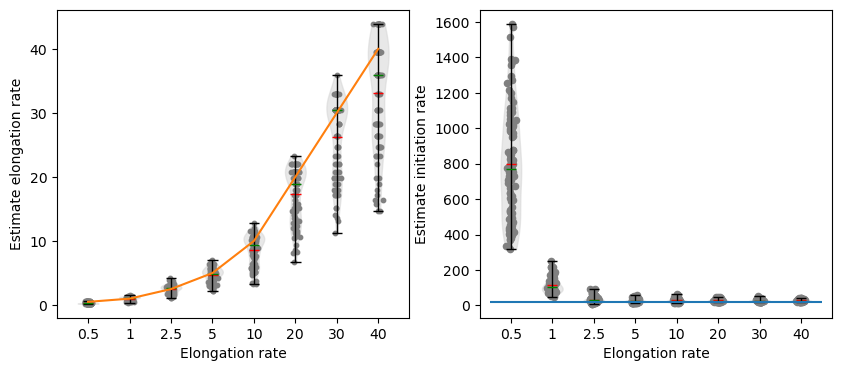

In [17]:
fig, ax = plt.subplots(1,2)

violin = ax[0].violinplot(dataset = [results[results.elongation_rate == i]["elongation_r"].values 
                                     for i in [0.5,1, 2.5, 5, 10, 20, 30, 40]
                          ],showmeans=True,
      showmedians=True)

for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    

violin = ax[1].violinplot(dataset = [results[results.elongation_rate == i]["init_translation_r"].values 
                                      for i in [0.5,1, 2.5, 5, 10, 20, 30, 40]
                                    ], showmeans=True,
      showmedians=True)


for pc in violin["bodies"]:
    pc.set_facecolor("lightgrey")
    pc.set_edgecolor("lightgrey")
    pc.set_alpha(0.5)

colors = ["black", "black", "black", "red", "green"]
i=0
for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
    vp = violin[partname]
    vp.set_edgecolor(colors[i])
    vp.set_linewidth(1)
    i+=1
    
group = 'elongation_rate'
column = 'elongation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[0].scatter(x, val, c='grey', alpha=1, s=10)
    
group = 'elongation_rate'
column = 'init_translation_r'
grouped = results.groupby(group)
names, vals, xs = [], [] ,[]
for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
clevels = np.linspace(0., 1., len(grouped))
for x, val, clevel in zip(xs, vals, clevels):
    ax[1].scatter(x, val, c='grey', alpha=1, s=20)
    
def set_axis_style(ax, labels):
    ax.set_xticks(np.arange(1, len(labels) + 1), labels=labels)
    ax.set_xlim(0.25, len(labels) + 0.75)
    ax.set_xlabel('Elongation rate')
# set style for the axes
labels = [0.5,1,2.5, 5,10,20,30,40]
for a in ax:
    set_axis_style(a, labels)

ax[0].set_ylabel("Estimate elongation rate")
ax[1].set_ylabel("Estimate initiation rate")
    
ax[0].plot([1,2,3,4,5,6,7,8],[0.5,1,2.5, 5,10,20,30,40])
ax[1].hlines(1/0.05, 0.5, 8.5)
fig.set_size_inches((10,4))
# fig.savefig(os.path.join(path_save, "results_elongation_rate_boxplot_original.eps"), dpi=300)

(0.0, 100.0)

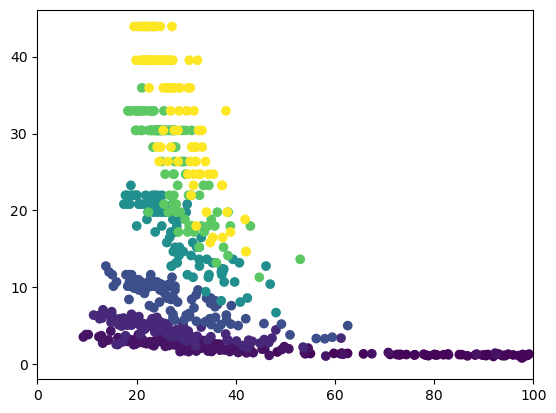

In [20]:
fig, ax = plt.subplots()
ax.scatter(results["init_translation_r"], results["elongation_r"], c=results["elongation_rate"])
ax.set_xlim(0,100)

In [124]:
from scipy.stats import bootstrap

d = (results[results.elongation_rate == 2.5]["elongation_r"].to_numpy(),)
bootstrap_ci = bootstrap(d,
                          np.mean, 
                          confidence_level=0.95,
                          method="percentile"
                         )
bootstrap_ci.confidence_interval

ConfidenceInterval(low=2.3603669694383713, high=2.634018058670752)

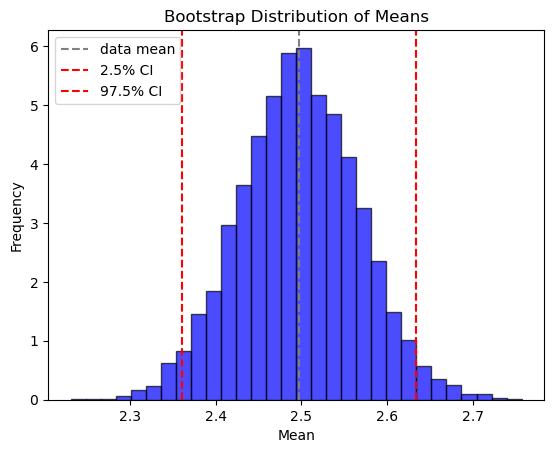

ConfidenceInterval(low=2.3603669694383713, high=2.634018058670752)
Bootstrap Mean Estimate: 	2.4974877009443857
Bootstrap Median Estimate: 	2.497420455397449
Bootstrap Standard Error: 	0.06925846956840728
Mean: 	2.497317264772489
Bootstrap Bias: 0.0001704361718966041


In [130]:
import matplotlib.pyplot as plt

plt.hist(bootstrap_ci.bootstrap_distribution, density=True, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Bootstrap Distribution of Means')
plt.xlabel('Mean')
plt.ylabel('Frequency')
plt.axvline(np.mean(d)  , color='grey', linestyle='dashed', label='data mean')
plt.axvline(bootstrap_ci.confidence_interval.low, color='red', linestyle='dashed', label='2.5% CI')
plt.axvline(bootstrap_ci.confidence_interval.high, color='red', linestyle='dashed', label='97.5% CI')
plt.legend()
plt.show()

print(bootstrap_ci.confidence_interval)
# calculate central tendency
mean_estimate = np.mean(bootstrap_ci.bootstrap_distribution)
median_estimate = np.median(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Mean Estimate: \t{mean_estimate}")
print(f"Bootstrap Median Estimate: \t{median_estimate}")

# measure variability
standard_error = np.std(bootstrap_ci.bootstrap_distribution)
print(f"Bootstrap Standard Error: \t{standard_error}")

# Assess bias
original_statistic = np.mean(d)  
print(f"Mean: \t{original_statistic}")
bias = np.mean(bootstrap_ci.bootstrap_distribution) - original_statistic
print(f"Bootstrap Bias: {bias}")



In [126]:
result_group = results.groupby(by='elongation_rate')[['elongation_r','init_translation_r']].mean()
result_group

,elongation_r,init_translation_r
elongation_rate,,
0.5,0.354123,0.001471
1.0,0.994995,0.009835
2.5,2.497317,0.039468
5.0,4.631341,0.043453
10.0,8.619040,0.039329
20.0,17.266466,0.037803
30.0,26.240754,0.037955
40.0,33.157179,0.036802


In [127]:
result_group["ratio"] = 100*result_group["elongation_r"]/result_group.index
result_group

,elongation_r,init_translation_r,ratio
elongation_rate,,,
0.5,0.354123,0.001471,70.824517
1.0,0.994995,0.009835,99.499456
2.5,2.497317,0.039468,99.892691
5.0,4.631341,0.043453,92.626810
10.0,8.619040,0.039329,86.190402
20.0,17.266466,0.037803,86.332331
30.0,26.240754,0.037955,87.469178
40.0,33.157179,0.036802,82.892948
